![HSV-AI Logo](https://hsv.ai/wp-content/uploads/2022/03/logo_v11_2022.png)

# Reporting


In [1]:
%reload_kedro

2022-03-26 23:17:52,948 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2022-03-26 23:17:52,971 - kedro.config.config - INFO - Config from path `/home/jlangley/git/product-recommendation/conf/vipin20` will override the following existing top-level config keys: alpha, factors, filter_value, iterations, maximum_order_size, minimum_order_size, regularization, seed, test_size, wandb_project
2022-03-26 23:17:52,973 - root - INFO - ** Kedro project productrec
2022-03-26 23:17:52,973 - root - INFO - Defined global variable `context`, `session` and `catalog`
2022-03-26 23:17:52,980 - root - INFO - Registered line magic `run_viz`


/home/jlangley/miniconda3/envs/product/lib/python3.8/site-packages/kedro/framework/context/context.py:488: UserWarning: Credentials not found in your Kedro project config.
No files found in ['/home/jlangley/git/product-recommendation/conf/base', '/home/jlangley/git/product-recommendation/conf/vipin20'] matching the glob pattern(s): ['credentials*', 'credentials*/**', '**/credentials*']
  warn(f"Credentials not found in your Kedro project config.\n{str(exc)}")


In [1]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import implicit
import scipy
from sklearn import metrics
from pandas.api.types import CategoricalDtype


# Available Files

Let's go ahead and look into some of these files and see what we can see.

In [2]:
transactions = catalog.load("transactions")
products_df = catalog.load("products")

2022-03-27 14:40:04,594 - kedro.io.data_catalog - INFO - Loading data from `transactions` (CSVDataSet)...
2022-03-27 14:40:04,748 - kedro.io.data_catalog - INFO - Loading data from `products` (CSVDataSet)...


In [5]:
from IPython.display import Markdown as md

order_count = len(pd.unique(transactions['order_id']))
customer_count = len(pd.unique(transactions['customer_id']))
product_count = len(pd.unique(transactions["product_id"]))

md(
'''
# Overall Data Report

The data consists of:
* {} orders
* {} customers
* {} products
* {} purchases

'''.format(order_count, customer_count, product_count, len(transactions)))



# Overall Data Report

The data consists of:
* 98666 orders
* 98666 customers
* 32951 products
* 112650 purchases



In [5]:
output = '''
# Top 5 customers based on product count purchased:

'''

user_counts = transactions[transactions['customer_id'] > 0].groupby(transactions.customer_id)['product_id'].count().sort_values(ascending=False)

user_counts.head()

five_total = 0
for index, row in user_counts[:5].iteritems():
    five_total += row

table_str = user_counts[:5].to_markdown()

output += table_str

output += '''

Other customers purchased {:,} items.

'''.format(len(transactions) - five_total)

md(output)



# Top 5 customers based on product count purchased:

|   customer_id |   product_id |
|--------------:|-------------:|
|        374661 |        15676 |
|        313131 |        11346 |
|        296016 |        10190 |
|        267708 |         9160 |
|        306726 |         5394 |

Other customers purchased 1,004,046 items.



In [6]:
df = user_counts[:10].reset_index().rename(columns={"customer_id":"Customer", "product_id":"Purchases"})

print(type(df))
print(df)

<class 'pandas.core.frame.DataFrame'>
   Customer  Purchases
0    374661      15676
1    313131      11346
2    296016      10190
3    267708       9160
4    306726       5394
5    321531       4758
6    307566       4120
7    274869       3636
8    278523       3344
9    300258       3274


In [7]:
output = '''
# Top 5 customers based on total orders:

'''

user_counts = transactions[transactions['customer_id'] > 0] \
    .drop_duplicates(['customer_id', 'order_id']) \
    .groupby('customer_id')['order_id'] \
    .count() \
    .sort_values(ascending=False)

five_total = 0
for index, row in user_counts[:5].iteritems():
    print(index)
    five_total += row

table_str = user_counts[:5].to_markdown()

output += table_str

output += '''

Other customers placed {:,} orders.

'''.format(order_count - five_total)

md(output)


267708
313131
374661
274869
321531



# Top 5 customers based on total orders:

|   customer_id |   order_id |
|--------------:|-----------:|
|        267708 |        206 |
|        313131 |        199 |
|        374661 |        124 |
|        274869 |         97 |
|        321531 |         91 |

Other customers placed 19,059 orders.



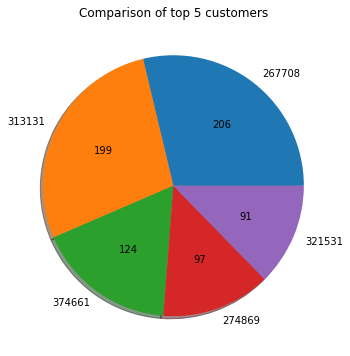

In [8]:
subplot = user_counts[:5].plot.pie(autopct=lambda p: '{:.0f}'.format(p * five_total / 100), shadow=True, figsize=(11, 6))

subplot.get_figure().gca().set_ylabel("")
subplot.get_figure().gca().set_xlabel("")
subplot.get_figure().gca().set_title("Comparison of top 5 customers")

plt.show()


[144, 442, 930, 2806]


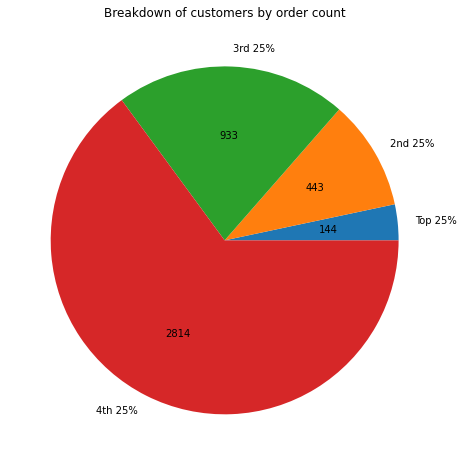

In [9]:
temp = (100. * user_counts / user_counts.sum()).sort_values(ascending=False)

count = 0
total = 0
buckets=[]
for val in temp:
    
    if total + val > 25:
        buckets.append(count)
        total = 0
        count = 0
        
    count+=1
    total+=val

print(buckets)
labels = ['Top 25%', '2nd 25%', '3rd 25%', '4th 25%']
fig1, ax1 = plt.subplots(figsize=(10, 8))
plt.pie(buckets, labels=labels, autopct=lambda p: '{:.0f}'.format(p * len(temp) / 100))
fig1.gca().set_title("Breakdown of customers by order count")
plt.show()

In [14]:
output = '''
# Top 5 products based on total count purchased:

'''

product_counts = transactions[transactions['product_id'] > 0].groupby(transactions.product_id)['quantity'].agg('sum').sort_values(ascending=False)

product_counts.head()

five_total = 0
for index, row in product_counts[:5].iteritems():
    five_total += row

table_str = product_counts[:5].to_markdown()

output += table_str

output += '''

Other products purchased {:,} times.

'''.format(transactions['quantity'].sum() - five_total)

md(output)



# Top 5 products based on total count purchased:

|   product_id |   quantity |
|-------------:|-----------:|
|       500703 |     485970 |
|      1787079 |     478290 |
|       486486 |     468198 |
|       466137 |     341526 |
|      1765617 |     330282 |

Other products purchased 31,358,820 times.



In [20]:
product_counts = transactions[transactions['product_id'] > 0] \
    .groupby(transactions.product_id)['quantity'] \
    .agg('sum'). \
    sort_values(ascending=False)

product_df = product_counts \
    .reset_index() \
    .rename(columns={"product_id":"Product", "quantity":"Quantity"})
print(type(product_df[:10]))

product_df = product_counts \
    .reset_index() \
    .rename(columns={"product_id":"Product", "quantity":"Quantity"})
print(type(product_df[:10]))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [10]:
output = '''
# Top 5 products based on counting orders that included them:

'''

product_counts = transactions[transactions['product_id'] > 0] \
    .drop_duplicates(['product_id', 'order_id']) \
    .groupby('product_id')['order_id'] \
    .count() \
    .sort_values(ascending=False)

five_total = 0
for index, row in product_counts[:5].iteritems():
    five_total += row

table_str = product_counts[:5].to_markdown()

output += table_str

output += '''

Other customers placed {:,} orders.

'''.format(order_count - five_total)

md(output)



# Top 5 products based on counting orders that included them:

|   product_id |   order_id |
|-------------:|-----------:|
|      1787079 |       2653 |
|      1787583 |       2265 |
|       470883 |       1988 |
|       998886 |       1948 |
|       435225 |       1565 |

Other customers placed 9,541 orders.



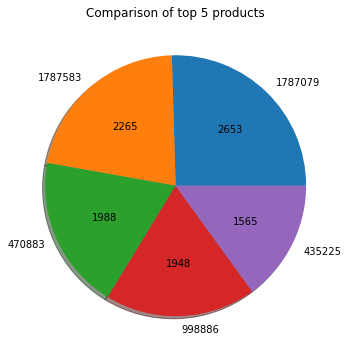

In [11]:
subplot = product_counts[:5].plot.pie(autopct=lambda p: '{:.0f}'.format(p * five_total / 100), shadow=True, figsize=(11, 6))

subplot.get_figure().gca().set_ylabel("")
subplot.get_figure().gca().set_xlabel("")
subplot.get_figure().gca().set_title("Comparison of top 5 products")

plt.show()

[144, 309, 574, 2098]


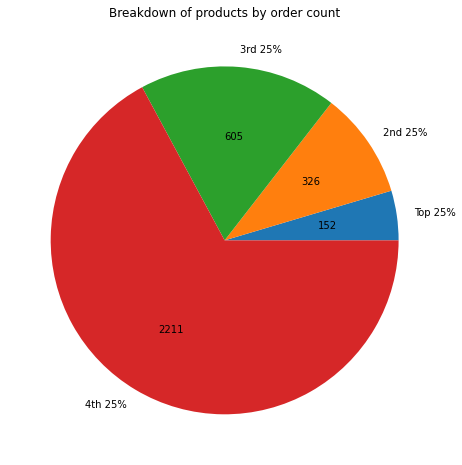

In [59]:
temp = (100. * product_counts / product_counts.sum()).sort_values(ascending=False)

count = 0
total = 0
buckets=[]
for val in temp:
    
    if total + val > 25:
        buckets.append(count)
        total = 0
        count = 0
        
    count+=1
    total+=val

print(buckets)
labels = ['Top 25%', '2nd 25%', '3rd 25%', '4th 25%']
fig1, ax1 = plt.subplots(figsize=(10, 8))
plt.pie(buckets, labels=labels, autopct=lambda p: '{:.0f}'.format(p * len(temp) / 100))
fig1.gca().set_title("Breakdown of products by order count")
plt.show()

In [12]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

grouped = transactions.groupby('order_id').agg({"product_id": lambda x: list(x)})
temp = grouped['product_id'].values


In [13]:
te = TransactionEncoder()

oht_ary = te.fit(temp).transform(temp, sparse=True)
sparse_df = pd.DataFrame.sparse.from_spmatrix(oht_ary, columns=te.columns_)
sparse_df.columns = [str(i) for i in sparse_df.columns]
top_sets = apriori(sparse_df, min_support=0.012, use_colnames=True, verbose=1, max_len=5)
top_sets['length'] = top_sets['itemsets'].apply(lambda x: len(x))

Processing 150 combinations | Sampling itemset size 54 3


In [14]:
set1 = top_sets[top_sets['length'] == 1].sort_values('support', ascending=False).iloc[0,1]
products_df['product_id'] = products_df['product_id'].astype(str)
for product in set1:
    print(products_df[products_df.product_id == product])

     product_id                     description
74      1787079  JUMBO  BAG BAROQUE BLACK WHITE
136     1787079         JUMBO BAG RED RETROSPOT
1235    1787079            JUMBO BAG STRAWBERRY


In [15]:
set2 = top_sets[top_sets['length'] == 2].sort_values('support', ascending=False).iloc[0,1]
products_df['product_id'] = products_df['product_id'].astype(str)
for product in set2:
    print(products_df[products_df.product_id == product])

     product_id                     description
74      1787079  JUMBO  BAG BAROQUE BLACK WHITE
136     1787079         JUMBO BAG RED RETROSPOT
1235    1787079            JUMBO BAG STRAWBERRY
    product_id              description
511     470106  JUMBO BAG PINK POLKADOT


In [16]:
set3 = top_sets[top_sets['length'] == 3].sort_values('support', ascending=False).iloc[0,1]
products_df['product_id'] = products_df['product_id'].astype(str)
for product in set3:
    print(products_df[products_df.product_id == product])

    product_id                       description
236     476679  ROSES REGENCY TEACUP AND SAUCER 
    product_id                     description
353     476658  PINK REGENCY TEACUP AND SAUCER
    product_id                      description
199     476637  GREEN REGENCY TEACUP AND SAUCER


In [17]:
set4 = top_sets[top_sets['length'] == 4].sort_values('support', ascending=False).iloc[0,1]
products_df['product_id'] = products_df['product_id'].astype(str)
for product in set4:
    print(products_df[products_df.product_id == product])

    product_id                       description
236     476679  ROSES REGENCY TEACUP AND SAUCER 
    product_id                     description
353     476658  PINK REGENCY TEACUP AND SAUCER
    product_id                      description
199     476637  GREEN REGENCY TEACUP AND SAUCER
    product_id               description
156     470883  REGENCY CAKESTAND 3 TIER


In [18]:
set5 = top_sets[top_sets['length'] == 5].sort_values('support', ascending=False).iloc[0,1]
products_df['product_id'] = products_df['product_id'].astype(str)
for product in set5:
    print(products_df[products_df.product_id == product])

IndexError: single positional indexer is out-of-bounds